In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
# Read data
rainfall = pd.read_csv('/content/drive/Shareddrives/Đồ án đa ngành/Flood_Forecast/Time series (Rain).csv')
tide = pd.read_csv('/content/drive/Shareddrives/Đồ án đa ngành/Flood_Forecast/Time series (Tide).csv', encoding = "ISO-8859-1")
flooded = pd.read_csv('/content/drive/Shareddrives/Đồ án đa ngành/Flood_Forecast/Time series (flooded volume).csv')

In [4]:
rainfall.head()

,I hour rainfall (mm),Unnamed: 1
0,NaN,NaN
1,Date & Time,"Kil (FG, NUIG, DerryB)"
2,1/1/2010 0:00,0
3,1/1/2010 1:00,0
4,1/1/2010 2:00,0


In [5]:
tide.head()

,Time,Water_Level_OD_Malin,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,01/01/2010 00:00,-1.500,NaN,NaN
1,NaN,NaN,NaN,NaN,01/01/2010 01:00,-1.700,NaN,NaN
2,NaN,NaN,NaN,NaN,01/01/2010 02:00,-0.965,NaN,NaN
3,NaN,NaN,NaN,NaN,01/01/2010 03:00,0.060,NaN,NaN
4,NaN,NaN,NaN,NaN,01/01/2010 04:00,1.026,NaN,NaN


In [6]:
flooded.head()

,Unnamed: 0,Unnamed: 1,Total flooded
0,Time,Seconds,volume (m3)
1,06/01/2010 00:00,0,49808.19372
2,06/01/2010 01:00,3600,50388.62414
3,06/01/2010 02:00,7200,50938.57857
4,06/01/2010 03:00,10800,51456.764


# PREPROCESSING DATA


In [7]:
rainfall_data = rainfall.iloc[2: , :]
rainfall_data.columns = ['timestamp', 'rainfall']
rainfall_data = rainfall_data.drop(index=rainfall_data[rainfall_data['rainfall'].isnull()].index)
rainfall_data.timestamp = pd.to_datetime(rainfall_data.timestamp, format="%d/%m/%Y %H:%M")
rainfall_data.timestamp = rainfall_data.timestamp.dt.strftime('%Y-%d-%m %H:%M:%S')

tide_data = tide.iloc[:,4:6]
tide_data.columns = ['timestamp', 'tide']
tide_data.timestamp = pd.to_datetime(tide_data.timestamp, format="%d/%m/%Y %H:%M")
tide_data.timestamp = tide_data.timestamp.dt.strftime('%Y-%d-%m %H:%M:%S')

flooded_data = flooded.iloc[1:,:]
flooded_data = flooded_data.drop(flooded_data.columns[1], axis=1)
flooded_data.columns = ['timestamp', 'flooded']
flooded_data.timestamp = pd.to_datetime(flooded_data.timestamp)
flooded_data.timestamp = flooded_data.timestamp.dt.strftime('%Y-%d-%m %H:%M:%S')

In [8]:
dataset_ = pd.concat([rainfall_data.set_index('timestamp'),tide_data.set_index('timestamp'),flooded_data.set_index('timestamp')], axis=1, join='inner')
dataset_.to_csv('/content/drive/Shareddrives/Đồ án đa ngành/Flood_Forecast/sample_data.csv')
dataset_.head(10)

,rainfall,tide,flooded
timestamp,,,
2010-01-06 00:00:00,0.066666667,-0.370,49808.19372
2010-01-06 01:00:00,0.1,-1.340,50388.62414
2010-01-06 02:00:00,0,-1.825,50938.57857
2010-01-06 03:00:00,0.033333333,-1.902,51456.764
2010-01-06 04:00:00,0,-1.498,51945.0758
2010-01-06 05:00:00,0,-0.823,52405.46288
2010-01-06 06:00:00,0,-0.175,52840.08047
2010-01-06 07:00:00,0,0.433,53251.67338
2010-01-06 08:00:00,0,1.153,53701.17872


In [9]:
dataset = dataset_.values
dataset

array([['0.066666667', -0.37, '49808.19372'],
       ['0.1', -1.34, '50388.62414'],
       ['0', -1.825, '50938.57857'],
       ...,
       ['0', -0.15, '6156285.693'],
       ['0', -1.097, '6133080.269'],
       ['0', -2.118, '6108817.302']], dtype=object)

# PREPARE DATA FOR MODEL

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [11]:
# Split data into train and test set
train_dataset, test_dataset = train_test_split(dataset, test_size=0.33, shuffle=False)
print('Train size: ', train_dataset.shape[0])
print('Test size: ', test_dataset.shape[0])

Train size:  16072
Test size:  7917


In [12]:
train_dataset.shape

(16072, 3)

In [13]:
# Scaling Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_dataset = scaler.fit_transform(train_dataset)
test_dataset = scaler.transform(test_dataset)

In [18]:
train_dataset[0:11]

array([[7.64119605e-03, 4.53970827e-01, 0.00000000e+00],
       [1.14617940e-02, 2.96758509e-01, 2.31249483e-05],
       [0.00000000e+00, 2.18152350e-01, 4.50357017e-05],
       [3.82059797e-03, 2.05672609e-01, 6.56807452e-05],
       [0.00000000e+00, 2.71150729e-01, 8.51355924e-05],
       [0.00000000e+00, 3.80551053e-01, 1.03477890e-04],
       [0.00000000e+00, 4.85575365e-01, 1.20793504e-04],
       [0.00000000e+00, 5.84116694e-01, 1.37191792e-04],
       [0.00000000e+00, 7.00810373e-01, 1.55100549e-04],
       [0.00000000e+00, 7.48784441e-01, 2.30492430e-04],
       [0.00000000e+00, 6.94651540e-01, 4.03719395e-04]])

In [19]:
def prepare_data(dataset, step_size=10): 
  data_X, data_Y = [], []
  for i in range(len(dataset)-step_size-1):
	  a = dataset[i:(i+step_size), :]
	  data_X.append(a)
	  data_Y.append(dataset[i + step_size, :])
  return np.array(data_X, dtype=np.float32), np.array(data_Y, dtype=np.float32)

step_size = 10
X_train, Y_train = prepare_data(train_dataset, step_size)
X_test, Y_test = prepare_data(test_dataset, step_size)

In [21]:
print(train_dataset[0:10,:])
print(train_dataset[10,:])

[[7.64119605e-03 4.53970827e-01 0.00000000e+00]
 [1.14617940e-02 2.96758509e-01 2.31249483e-05]
 [0.00000000e+00 2.18152350e-01 4.50357017e-05]
 [3.82059797e-03 2.05672609e-01 6.56807452e-05]
 [0.00000000e+00 2.71150729e-01 8.51355924e-05]
 [0.00000000e+00 3.80551053e-01 1.03477890e-04]
 [0.00000000e+00 4.85575365e-01 1.20793504e-04]
 [0.00000000e+00 5.84116694e-01 1.37191792e-04]
 [0.00000000e+00 7.00810373e-01 1.55100549e-04]
 [0.00000000e+00 7.48784441e-01 2.30492430e-04]] ,
[0.00000000e+00 6.94651540e-01 4.03719395e-04]


In [27]:
X_train.shape

(16061, 10, 3)

In [26]:
Y_train[0]

array([0.0000000e+00, 6.9465154e-01, 4.0371940e-04], dtype=float32)

In [15]:
print(X_train.shape)
print(Y_train.shape)

(16061, 10, 3)
(16061, 3)


# TRAIN MODEL

In [16]:
n_features = 3
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], n_features)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 3))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 2)

Epoch 1/100
502/502 - 19s - loss: 0.0112 - 19s/epoch - 39ms/step
Epoch 2/100
502/502 - 6s - loss: 0.0045 - 6s/epoch - 13ms/step
Epoch 3/100
502/502 - 6s - loss: 0.0036 - 6s/epoch - 13ms/step
Epoch 4/100
502/502 - 6s - loss: 0.0029 - 6s/epoch - 13ms/step
Epoch 5/100
502/502 - 6s - loss: 0.0025 - 6s/epoch - 13ms/step
Epoch 6/100
502/502 - 6s - loss: 0.0022 - 6s/epoch - 13ms/step
Epoch 7/100
502/502 - 7s - loss: 0.0021 - 7s/epoch - 13ms/step
Epoch 8/100
502/502 - 6s - loss: 0.0019 - 6s/epoch - 13ms/step
Epoch 9/100
502/502 - 6s - loss: 0.0018 - 6s/epoch - 13ms/step
Epoch 10/100
502/502 - 6s - loss: 0.0018 - 6s/epoch - 13ms/step
Epoch 11/100
502/502 - 6s - loss: 0.0018 - 6s/epoch - 13ms/step
Epoch 12/100
502/502 - 6s - loss: 0.0017 - 6s/epoch - 13ms/step
Epoch 13/100
502/502 - 6s - loss: 0.0017 - 6s/epoch - 13ms/step
Epoch 14/100
502/502 - 6s - loss: 0.0016 - 6s/epoch - 13ms/step
Epoch 15/100
502/502 - 7s - loss: 0.0016 - 7s/epoch - 15ms/step
Epoch 16/100
502/502 - 6s - loss: 0.0016 - 6s/e

In [17]:
model.save('/content/drive/Shareddrives/Đồ án đa ngành/Flood_Forecast/model.h5')

In [18]:
model = load_model('/content/drive/Shareddrives/Đồ án đa ngành/Flood_Forecast/model.h5')

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sm
import math

In [20]:
# PREDICTION
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(Y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(Y_test)

In [21]:
# TRAINING EVALUATE

# RMSE: to measure the deviation between the observed value and the true value
train_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
# NSE: Nash efficiency coefficient
train_NSE = 1-(np.sum((trainPredict-trainY)**2)/np.sum((trainY-np.mean(trainY))**2))
# R2
train_R2 = sm.r2_score(trainY, trainPredict)
print('Train RMSE: %.6f' % (train_RMSE))
print('Train NSE: %.6f' % (train_NSE))
print('Train R2: %.6f' % (train_R2))

print('\n')

# TEST EVALUATE
test_RMSE = math.sqrt(mean_squared_error(testY, testPredict))
# NSE: Nash efficiency coefficient
test_NSE = 1-(np.sum((testPredict-testY)**2)/np.sum((testY-np.mean(testY))**2))
# R2
test_R2 = sm.r2_score(testY, testPredict)
print('Test RMSE: %.6f' % (test_RMSE))
print('Test NSE: %.6f' % (test_NSE))
print('Test R2: %.6f' % (test_R2))


Train RMSE: 202148.222213
Train NSE: 0.998103
Train R2: 0.765445


Test RMSE: 127129.354974
Test NSE: 0.999087
Test R2: 0.763385


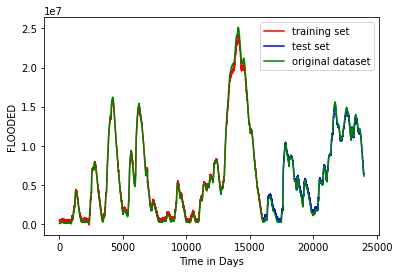

In [22]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(dataset[:,-1].reshape(dataset.shape[0], 1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict[:,-1].reshape(trainPredict.shape[0],1)

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(dataset[:,-1].reshape(dataset.shape[0], 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(dataset)-1, :] = testPredict[:,-1].reshape(testPredict.shape[0],1)

# DE-NORMALIZING MAIN DATASET 
datascaled = scaler.inverse_transform(scaler.transform(dataset))
datascaled = datascaled[:,-1].reshape(datascaled.shape[0], 1)
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'test set')
plt.plot(datascaled, 'g', label = 'original dataset')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('FLOODED')
plt.show()